In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import feature_extraction, model_selection, metrics, svm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
import torch
import torch.nn as nn

In [2]:
#Import data
url='https://drive.google.com/file/d/1Q08yxW1npmnzr6pFThqZ_1gEJ2LRo8vm/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
raw_data = pd.read_csv(dwn_url, encoding = "iso-8859-1")
print(raw_data.head())
raw_data.shape

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


(5572, 5)

In [3]:
#Check missing value first
raw_data.isna().sum()

#The data should contain 2 columns, one with labels, one with text.
#Let's see what do 3-5 columns contain
not_na_data = raw_data[raw_data.iloc[:,2:5].notna().any(axis=1)]
not_na_data.head()
# not_na_data.head().to_csv("/content/drive/MyDrive/not_na_data.csv")

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


In [4]:
#The right columns still contain meaningful text, let's concat them with v2 column
combined_text = raw_data.iloc[:,1:5].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df = pd.DataFrame({'label': raw_data['v1'], 'text': combined_text})
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


<Axes: xlabel='label'>

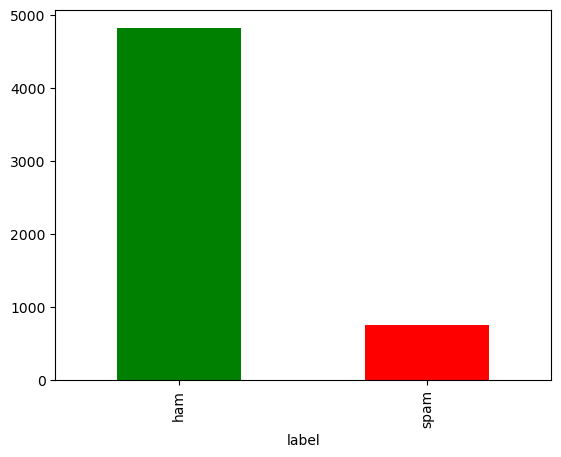

In [5]:
# Visualization shows the df is unbalanced, we will deal with that later

df.label.value_counts().plot(kind='bar', color = ["green", "red"])



In [6]:
# label to categorical variable
labels = df.label.map({'ham':0, 'spam':1})

features = df.text

#train_test_val split
temp_features, test_features, temp_labels, test_labels = model_selection.train_test_split(features, labels, stratify=labels, test_size=0.15, random_state=42)

train_features, val_features, train_labels, val_labels = model_selection.train_test_split(temp_features, temp_labels, stratify=temp_labels, test_size=0.17, random_state=42)

#train, test, val dist: 0.7, 0.15, 0.15
train_features.shape, val_features.shape, test_features.shape

((3930,), (806,), (836,))

In [7]:
#Obviously, remove stop words first
stop_words = feature_extraction.text.TfidfVectorizer(stop_words='english')
train_features = stop_words.fit_transform(train_features)
val_features = stop_words.transform(val_features)
test_features = stop_words.transform(test_features)
np.shape(train_features), np.shape(val_features), np.shape(test_features)

((3930, 7013), (806, 7013), (836, 7013))

In [8]:
ham = (labels == 0).sum() / len(labels)
spam = (labels == 1).sum() / len(labels)
print("ham:", ham)
print("spam:", spam)

ham: 0.8659368269921034
spam: 0.13406317300789664


In [9]:
# SMOTE for moderate balancing
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Don't fully balance
train_features, train_labels = smote.fit_resample(train_features, train_labels)

In [10]:
# Check ratio after SMOTE
class_counts = Counter(train_labels)
ratio = class_counts[0] / class_counts[1]
print(class_counts)
print(ratio)

Counter({0: 3403, 1: 1020})
3.3362745098039217


In [11]:
# Use SVM to train the model

svm_model = svm.SVC(C=1, kernel='linear',
    class_weight="balanced",
    probability=True, random_state=42)

svm_model.fit(train_features, train_labels)

# Model evaluation
print("Model Evaluation on Validation Set")
print(metrics.classification_report(val_labels, svm_model.predict(val_features)))
print("")
print("Confusion Matrix")
print(metrics.confusion_matrix(val_labels, svm_model.predict(val_features)))
print("")
# ROC_AUC score
print("ROC_AUC score:")
print(metrics.roc_auc_score(val_labels, svm_model.predict_proba(val_features)[:, 1]))

print("")
print("")
print("")
print("")

# Model prediction
print("Model Prediction on Test Set")
print(metrics.classification_report(test_labels, svm_model.predict(test_features)))
print("")
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, svm_model.predict(test_features)))
print("")

# ROC_AUC score
print("ROC_AUC score:")
print(metrics.roc_auc_score(test_labels, svm_model.predict_proba(test_features)[:, 1]))

Model Evaluation on Validation Set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       698
           1       0.99      0.93      0.96       108

    accuracy                           0.99       806
   macro avg       0.99      0.96      0.98       806
weighted avg       0.99      0.99      0.99       806


Confusion Matrix
[[697   1]
 [  8 100]]

ROC_AUC score:
0.9938979093706889




Model Prediction on Test Set
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       0.99      0.88      0.93       112

    accuracy                           0.98       836
   macro avg       0.99      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836


Confusion Matrix
[[723   1]
 [ 13  99]]

ROC_AUC score:
0.9849546172059985


In [12]:
# Hyperparameter Tuning
param_grid = {'C': np.arange(0.1, 2.01, 0.1), 'kernel': ['rbf', 'poly', 'sigmoid'], 'class_weight': [{0:1, 1:3}, 'balanced']}

# Train models with different parameters
models = []
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for weights in param_grid['class_weight']:
            model = svm.SVC(C=C, kernel=kernel,
                       class_weight=weights,
                       probability=True)
            model.fit(train_features, train_labels)

            # Evaluate on validation set
            val_score = metrics.recall_score(val_labels, model.predict(val_features))
            models.append((model, val_score))

# Select best model based on recall
print(models)
max_recall_model = max(models, key=lambda x: x[1])
print(max_recall_model)
max_recall_model = max_recall_model[0]

[(SVC(C=0.1, class_weight={0: 1, 1: 3}, probability=True), 0.7685185185185185), (SVC(C=0.1, class_weight='balanced', probability=True), 0.7407407407407407), (SVC(C=0.1, class_weight={0: 1, 1: 3}, kernel='poly', probability=True), 0.3055555555555556), (SVC(C=0.1, class_weight='balanced', kernel='poly', probability=True), 0.2777777777777778), (SVC(C=0.1, class_weight={0: 1, 1: 3}, kernel='sigmoid', probability=True), 0.8888888888888888), (SVC(C=0.1, class_weight='balanced', kernel='sigmoid', probability=True), 0.8888888888888888), (SVC(C=0.2, class_weight={0: 1, 1: 3}, probability=True), 0.8518518518518519), (SVC(C=0.2, class_weight='balanced', probability=True), 0.8425925925925926), (SVC(C=0.2, class_weight={0: 1, 1: 3}, kernel='poly', probability=True), 0.4722222222222222), (SVC(C=0.2, class_weight='balanced', kernel='poly', probability=True), 0.4351851851851852), (SVC(C=0.2, class_weight={0: 1, 1: 3}, kernel='sigmoid', probability=True), 0.8796296296296297), (SVC(C=0.2, class_weight='

Model Prediction on Test Set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.95      0.90      0.93       112

    accuracy                           0.98       836
   macro avg       0.97      0.95      0.96       836
weighted avg       0.98      0.98      0.98       836


Confusion Matrix
[[719   5]
 [ 11 101]]

ROC_AUC score:
0.9844304952644041

ROC Curve:


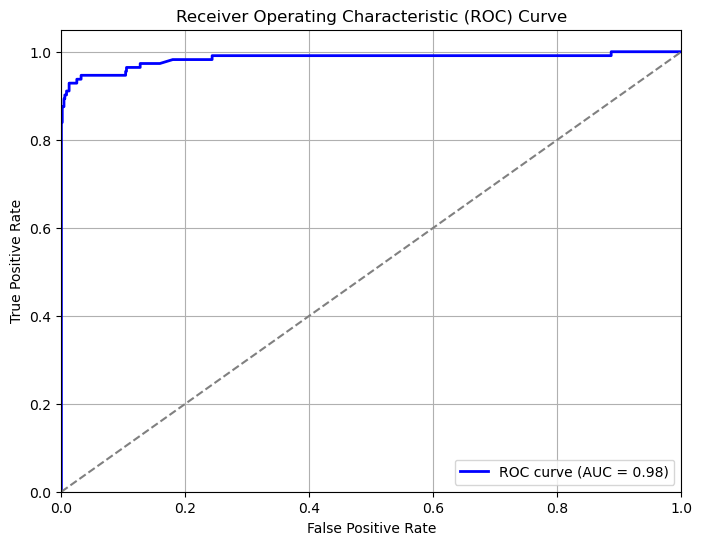

In [13]:
# Final evaluation
import matplotlib.pyplot as plt

print("Model Prediction on Test Set")
print(metrics.classification_report(test_labels, max_recall_model.predict(test_features)))
print("")
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, max_recall_model.predict(test_features)))
print("")
print("ROC_AUC score:")
print(metrics.roc_auc_score(test_labels, max_recall_model.predict_proba(test_features)[:, 1]))
print("")
print("ROC Curve:")
# Compute False Positive Rate (FPR), True Positive Rate (TPR), and Thresholds
fpr, tpr, thresholds = metrics.roc_curve(test_labels, max_recall_model.predict_proba(test_features)[:, 1])

# Compute Area Under the Curve (AUC)
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [14]:
# Use RoBERTa, firstly, train_test_val split
temp_features, test_features, temp_labels, test_labels = model_selection.train_test_split(features, labels, stratify=labels, test_size=0.15, random_state=42)
train_features, val_features, train_labels, val_labels = model_selection.train_test_split(temp_features, temp_labels, stratify=temp_labels, test_size=0.17, random_state=42)

#train, test, val dist: 0.7, 0.15, 0.15
train_features.shape, val_features.shape, test_features.shape

((3930,), (806,), (836,))

In [15]:
# Set random seed
torch.manual_seed(42)

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def prepare_data(texts, labels, max_length=128):
    # Tokenize texts
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')

    # Create dataset
    dataset = TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )
    return dataset

In [17]:
def create_balanced_sampler(labels):
    # Calculate class weights
    class_counts = np.bincount(labels)
    total_samples = len(labels)

    # Weight for each class (inverse of frequency)
    class_weights = total_samples / (len(class_counts) * class_counts)

    # Weight for each sample
    sample_weights = [class_weights[label] for label in labels]

    # Create sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(labels),
        replacement=True
    )
    return sampler

In [18]:
from transformers import get_linear_schedule_with_warmup

def compute_recall(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def train_model(train_loader, val_loader, model, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Calculate class weights for loss function
    labels = train_loader.dataset.tensors[2].numpy()
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = torch.FloatTensor(total_samples / (len(class_counts) * class_counts)).to(device)

    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(len(train_loader) * epochs * 0.01),
        num_training_steps=len(train_loader) * epochs
    )

    train_losses = []
    val_losses = []

    # Track best model
    best_recall = 0
    best_model_state = None
    best_epoch = 0
    best_avg_train_loss = 1
    best_avg_val_loss = 1

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                epoch_val_loss += loss.item()

                # Get predictions
                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Compute recall
        current_recall = compute_recall(
            np.array(val_true),
            np.array(val_preds)
        )

        # Save best model
        if current_recall >= best_recall and avg_train_loss <= best_avg_train_loss and avg_val_loss <= best_avg_val_loss:
            best_recall = current_recall
            best_avg_val_loss, best_avg_train_loss = avg_val_loss, avg_train_loss
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1

        print(f'Epoch {epoch+1}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Recall: {current_recall:.4f}')
        print(f'Best Recall So Far: {best_recall:.4f} (Epoch {best_epoch})')
        print('-' * 50)

    print(f'\nBest Model Recall: {best_recall:.4f} from epoch {best_epoch}')

    # Restore best model
    model.load_state_dict(best_model_state)

    return train_losses, val_losses, best_recall, best_epoch


In [19]:
def get_predictions(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)

            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

In [20]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_metrics(y_true, y_pred, y_prob):
    # Confusion Matrix
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    cm = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    print('-' * 50)
    print("Recall:")
    print(metrics.recall_score(y_true, y_pred))

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(metrics.classification_report(y_true, y_pred))

In [21]:
# Prepare data
train_dataset = prepare_data(train_features.tolist(), train_labels.tolist())
val_dataset = prepare_data(val_features.tolist(), val_labels.tolist())
test_dataset = prepare_data(test_features.tolist(), test_labels.tolist())

# Create balanced sampler for training data
sampler = create_balanced_sampler(train_labels.tolist())

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)  # Use sampler for training
val_loader = DataLoader(val_dataset, batch_size=16)  # Keep validation as is
test_loader = DataLoader(test_dataset, batch_size=16)  # Keep test as is

In [22]:
# Train model with recall tracking
train_losses, val_losses, best_recall, best_epoch = train_model(train_loader, val_loader, roberta_model, 5)

print(f"Best model achieved {best_recall:.4f} recall at epoch {best_epoch}")


Epoch 1:
Training Loss: 0.1040
Validation Loss: 0.0308
Validation Recall: 0.9907
Best Recall So Far: 0.9907 (Epoch 1)
--------------------------------------------------
Epoch 2:
Training Loss: 0.0129
Validation Loss: 0.0150
Validation Recall: 1.0000
Best Recall So Far: 1.0000 (Epoch 2)
--------------------------------------------------
Epoch 3:
Training Loss: 0.0056
Validation Loss: 0.0097
Validation Recall: 1.0000
Best Recall So Far: 1.0000 (Epoch 3)
--------------------------------------------------
Epoch 4:
Training Loss: 0.0009
Validation Loss: 0.0256
Validation Recall: 0.9815
Best Recall So Far: 1.0000 (Epoch 3)
--------------------------------------------------
Epoch 5:
Training Loss: 0.0005
Validation Loss: 0.0270
Validation Recall: 0.9815
Best Recall So Far: 1.0000 (Epoch 3)
--------------------------------------------------

Best Model Recall: 1.0000 from epoch 3
Best model achieved 1.0000 recall at epoch 3


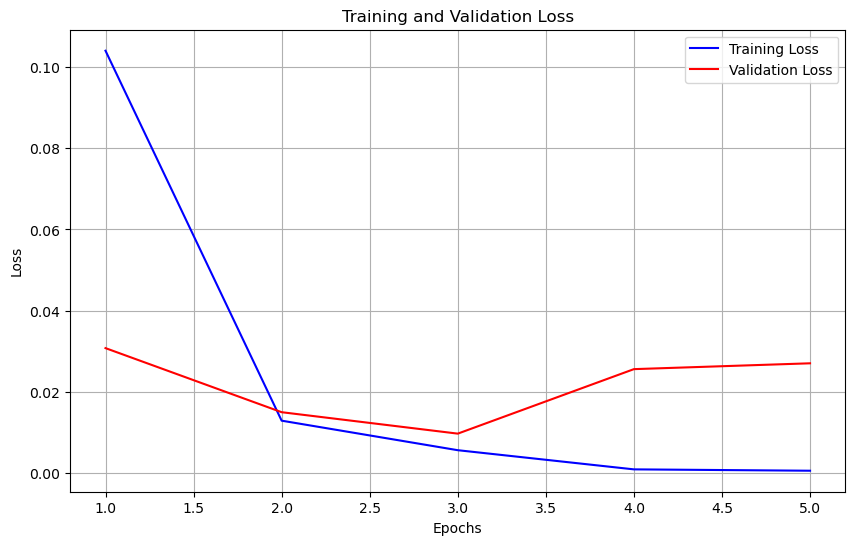

--------------------------------------------------
Recall:
0.9821428571428571


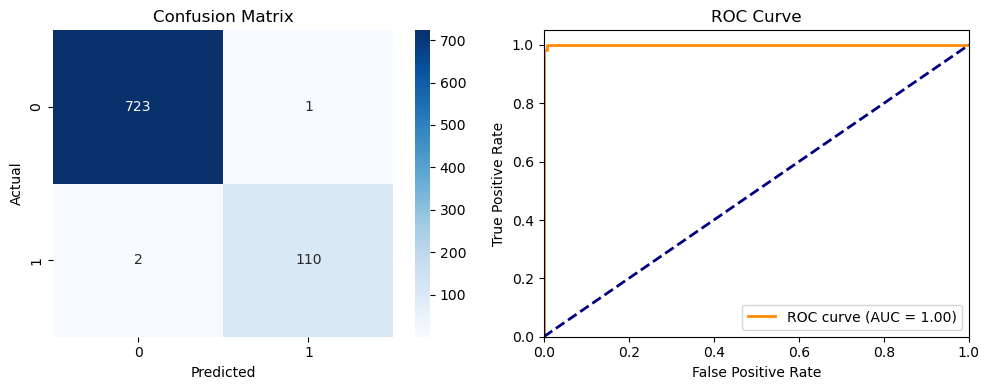


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       0.99      0.98      0.99       112

    accuracy                           1.00       836
   macro avg       0.99      0.99      0.99       836
weighted avg       1.00      1.00      1.00       836



In [23]:
# Plot losses
plot_losses(train_losses, val_losses)

# Get predictions using best model
y_pred, y_prob, y_true = get_predictions(roberta_model, test_loader)
plot_metrics(y_true, y_pred, y_prob)

In [24]:
# Use LSTM, firstly, train_test_val split
temp_features, test_features, temp_labels, test_labels = model_selection.train_test_split(features, labels, stratify=labels, test_size=0.15, random_state=42)
train_features, val_features, train_labels, val_labels = model_selection.train_test_split(temp_features, temp_labels, stratify=temp_labels, test_size=0.17, random_state=42)

#train, test, val dist: 0.7, 0.15, 0.15
train_features.shape, val_features.shape, test_features.shape

((3930,), (806,), (836,))

In [25]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Convert text to indices
        indices = [self.vocab.get(word, 0) for word in text.split()]
        
        # Pad or truncate
        if len(indices) < self.max_len:
            indices += [0] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
            
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           n_layers, 
                           bidirectional=True, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 for bidirectional
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)
        return self.fc(hidden)

def create_vocabulary(texts, min_freq=2):
    # Count word frequencies
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())
    
    # Create vocabulary
    vocab = {'<pad>': 0}  # padding token
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    
    return vocab

def lstm_train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    best_val_recall = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            optimizer.zero_grad()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels.float())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            
        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        epoch_loss = 0
        val_predictions = []
        val_labels = []
        
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                predictions = model(texts).squeeze(1)
                loss = criterion(predictions, labels.float())
                
                epoch_loss += loss.item()
                val_predictions.extend((predictions > 0).long().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss = epoch_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Calculate recall
        val_recall = metrics.classification_report(val_labels, val_predictions, output_dict=True)['1']['recall']
        
        print(f'Epoch {epoch+1}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Recall: {val_recall:.4f}')
        
        # Save best model
        if val_recall > best_val_recall:
            best_val_recall = val_recall
            best_model_state = model.state_dict().copy()
            print(f'New best recall: {val_recall:.4f}')
        
        print('-' * 60)
    
    # Load best model
    model.load_state_dict(best_model_state)
    return train_losses, val_losses, best_val_recall

def lstm_plot_metrics(model, test_loader, device):
    model.eval()
    predictions = []
    probabilities = []
    true_labels = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            outputs = model(texts).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            true_labels.extend(labels.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    probabilities = np.array(probabilities)
    true_labels = np.array(true_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    cm = metrics.confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Plot ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = metrics.roc_curve(true_labels, probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(metrics.classification_report(true_labels, predictions))

def lstm_plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
# Hyperparameters
EMBEDDING_DIM = 1000
HIDDEN_DIM = 256
N_LAYERS = 3
DROPOUT = 0.5
BATCH_SIZE = 16
LEARNING_RATE = 0.001

# Create vocabulary
vocab = create_vocabulary(train_features)

# Create datasets
lstm_train_dataset = TextDataset(train_features.tolist(), train_labels.tolist(), vocab)
lstm_val_dataset = TextDataset(val_features.tolist(), val_labels.tolist(), vocab)
lstm_test_dataset = TextDataset(test_features.tolist(), test_labels.tolist(), vocab)

# Count the occurrences of each label
class_counts = Counter(train_labels.tolist())

# Create data loaders with weighted sampling for training
lstm_train_weights = [1/class_counts[label] for label in train_labels.tolist()]
lstm_train_sampler = WeightedRandomSampler(lstm_train_weights, len(lstm_train_weights))

lstm_train_loader = DataLoader(lstm_train_dataset, batch_size=BATCH_SIZE, sampler=lstm_train_sampler)
lstm_val_loader = DataLoader(lstm_val_dataset, batch_size=BATCH_SIZE)
lstm_test_loader = DataLoader(lstm_test_dataset, batch_size=BATCH_SIZE)

In [27]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMClassifier(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT).to(device)

# Loss and optimizer
lstm_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([9.0]).to(device))  # For 90/10 imbalance
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

In [28]:
# Train model
lstm_train_losses, lstm_val_losses, lstm_best_recall = lstm_train_model(
    lstm_model, lstm_train_loader, lstm_val_loader, lstm_criterion, lstm_optimizer, device)

Epoch 1:
Training Loss: 0.6440
Validation Loss: 0.4853
Validation Recall: 0.9074
New best recall: 0.9074
------------------------------------------------------------
Epoch 2:
Training Loss: 0.2254
Validation Loss: 0.7123
Validation Recall: 0.8981
------------------------------------------------------------
Epoch 3:
Training Loss: 0.0492
Validation Loss: 0.7782
Validation Recall: 0.8889
------------------------------------------------------------
Epoch 4:
Training Loss: 0.0419
Validation Loss: 0.8792
Validation Recall: 0.9167
New best recall: 0.9167
------------------------------------------------------------
Epoch 5:
Training Loss: 0.0180
Validation Loss: 0.8718
Validation Recall: 0.8981
------------------------------------------------------------
Epoch 6:
Training Loss: 0.0147
Validation Loss: 0.9883
Validation Recall: 0.9167
------------------------------------------------------------
Epoch 7:
Training Loss: 0.0262
Validation Loss: 0.8570
Validation Recall: 0.9167
-------------------

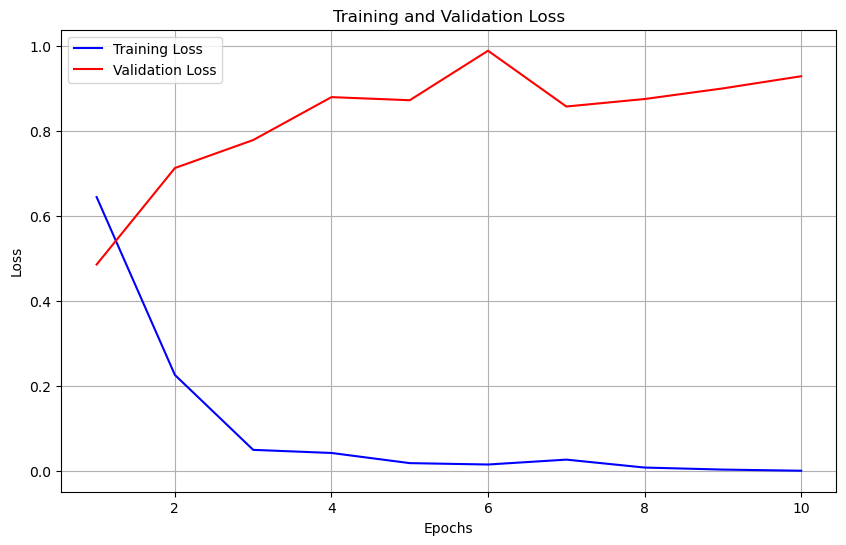

In [29]:
# Plot losses
lstm_plot_losses(lstm_train_losses, lstm_val_losses)

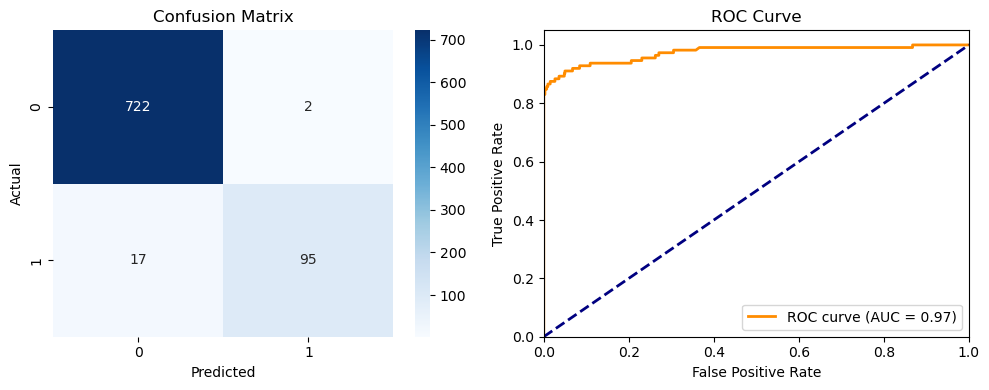


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       0.98      0.85      0.91       112

    accuracy                           0.98       836
   macro avg       0.98      0.92      0.95       836
weighted avg       0.98      0.98      0.98       836



In [30]:
# Plot metrics
lstm_plot_metrics(lstm_model, lstm_test_loader, device)

In [39]:
def lstm_plot(model, test_loader, device):
    model.eval()
    predictions = []
    probabilities = []
    true_labels = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            outputs = model(texts).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            true_labels.extend(labels.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    probabilities = np.array(probabilities)
    true_labels = np.array(true_labels)
    
    fpr, tpr, _ = metrics.roc_curve(true_labels, probabilities)
    roc_auc = metrics.auc(fpr, tpr)

    return  roc_auc, fpr, tpr

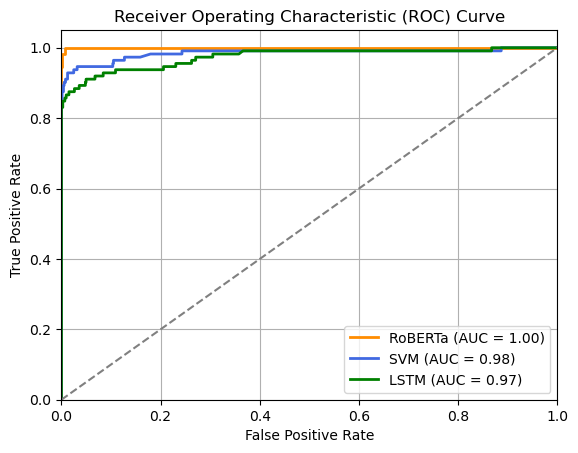

In [42]:
# Prepare data
roc_auc = metrics.auc(fpr, tpr)

roberta_fpr, roberta_tpr, _ = metrics.roc_curve(y_true, y_prob)
roberta_roc_auc = metrics.auc(roberta_fpr, roberta_tpr)

lstm_roc_auc, lstm_fpr, lstm_tpr = lstm_plot(lstm_model, lstm_test_loader, device)

# Plot ROC curve for SVM, RoBERTa, and LSTM
plt.plot(roberta_fpr, roberta_tpr, color='darkorange', lw=2, label=f'RoBERTa (AUC = {roberta_roc_auc:.2f})')
plt.plot(fpr, tpr, color='royalblue', lw=2, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot(lstm_fpr, lstm_tpr, color='green', lw=2, 
             label=f'LSTM (AUC = {lstm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()